In [1]:
#import necessary packages 
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns

/Users/hopeknopf/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in data 
df = pd.read_csv('apm_cleaned_data1.csv',encoding='utf-8-sig')
df.drop(df.columns[[0]], axis=1, inplace=True) #drop first column
df.head()

,U_ID,age,female,college,church,extrovert,teeth,attention,talkative,sport,...,upbringing,anxiety,newppl,carelike,group,Netflix,urban,politics,convos,y
0,1&32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1
1,1&41,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,1
2,1&33,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,1
3,4&95,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,1
4,4&95,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,1


In [3]:
#define x and y
y = df['y'].values
X = df.iloc[:,1:-1]
#test train split twice to get test and validation and training sets and stratify y


In [4]:
X2 = np.array(X)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=0)


In [6]:

"""
Created on Dec 21, 2012
@author: Alexandre
"""
import numpy as np

class PUAdapter(object):
    """
    Adapts any probabilistic binary classifier to positive-unlabled learning using the PosOnly method proposed by
    Elkan and Noto:
    Elkan, Charles, and Keith Noto. \"Learning classifiers from only positive and unlabeled data.\"
    Proceeding of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2008.
    """


    def __init__(self, estimator, hold_out_ratio=0.1, precomputed_kernel=False):
        """
        estimator -- An estimator of p(s=1|x) that must implement:
                     * predict_proba(X): Takes X, which can be a list of feature vectors or a precomputed
                                         kernel matrix and outputs p(s=1|x) for each example in X
                     * fit(X,y): Takes X, which can be a list of feature vectors or a precomputed
                                 kernel matrix and takes y, which are the labels associated to the
                                 examples in X
        hold_out_ratio -- The ratio of training examples that must be held out of the training set of examples
                          to estimate p(s=1|y=1) after training the estimator
        precomputed_kernel -- Specifies if the X matrix for predict_proba and fit is a precomputed kernel matrix
        """
        self.estimator = estimator
        self.c = 1.0
        self.hold_out_ratio = hold_out_ratio
        
        if precomputed_kernel:
            self.fit = self.__fit_precomputed_kernel
        else:
            self.fit = self.__fit_no_precomputed_kernel

        self.estimator_fitted = False
        
    def __str__(self):
        return 'Estimator:' + str(self.estimator) + '\n' + 'p(s=1|y=1,x) ~= ' + str(self.c) + '\n' + \
            'Fitted: ' + str(self.estimator_fitted)
    
    
    def __fit_precomputed_kernel(self, X, y):
        """
        Fits an estimator of p(s=1|x) and estimates the value of p(s=1|y=1) using a subset of the training examples
        X -- Precomputed kernel matrix
        y -- Labels associated to each example in X (Positive label: 1.0, Negative label: -1.0)
        """
        positives = np.where(y == 1.)[0]
        hold_out_size = int(np.ceil(len(positives) * self.hold_out_ratio))

        if len(positives) <= hold_out_size:
            raise('Not enough positive examples to estimate p(s=1|y=1,x). Need at least ' + str(hold_out_size + 1) + '.')
        
        np.random.shuffle(positives)
        hold_out = positives[:hold_out_size]
        
        #Hold out test kernel matrix
        X_test_hold_out = X[hold_out]
        keep = list(set(np.arange(len(y))) - set(hold_out))
        X_test_hold_out = X_test_hold_out[:,keep]
        
        #New training kernel matrix
        X = X[:, keep]
        X = X[keep]

        y = np.delete(y, hold_out)
        
        self.estimator.fit(X, y)
        
        hold_out_predictions = self.estimator.predict_proba(X_test_hold_out)
        
        try:
            hold_out_predictions = hold_out_predictions[:,1]
        except:
            pass
        
        c = np.mean(hold_out_predictions)
        self.c = c
        
        self.estimator_fitted = True
        
        
    def __fit_no_precomputed_kernel(self, X, y):
        """
        Fits an estimator of p(s=1|x) and estimates the value of p(s=1|y=1,x)
        X -- List of feature vectors
        y -- Labels associated to each feature vector in X (Positive label: 1.0, Negative label: -1.0)
        """
        positives = np.where(y == 1.)[0] #find where label is positive
        hold_out_size = int(np.ceil(len(positives) * self.hold_out_ratio)) 

        if len(positives) <= hold_out_size:
            raise('Not enough positive examples to estimate p(s=1|y=1,x). Need at least ' + str(hold_out_size + 1) + '.')
        
        np.random.shuffle(positives) #randomly select positives to remove
        hold_out = positives[:hold_out_size] 
        X_hold_out = X[hold_out]
        X = np.delete(X, hold_out,0)
        y = np.delete(y, hold_out)
        
        self.estimator.fit(X, y)
        
        hold_out_predictions = self.estimator.predict_proba(X_hold_out)
        
        try:
            hold_out_predictions = hold_out_predictions[:,1]
        except:
            pass
        
        c = np.mean(hold_out_predictions)
        self.c = c

        self.estimator_fitted = True
        
    
    def predict_proba(self, X):
        """
        Predicts p(y=1|x) using the estimator and the value of p(s=1|y=1) estimated in fit(...)
        X -- List of feature vectors or a precomputed kernel matrix
        """
        if not self.estimator_fitted:
            raise Exception('The estimator must be fitted before calling predict_proba(...).')

        probabilistic_predictions = self.estimator.predict_proba(X)
        
        try:
            probabilistic_predictions = probabilistic_predictions[:,1]
        except:
            pass
        
        return probabilistic_predictions / self.c
    
    
    def predict(self, X, treshold=0.5):
        """
        Assign labels to feature vectors based on the estimator's predictions
        X -- List of feature vectors or a precomputed kernel matrix
        treshold -- The decision treshold between the positive and the negative class
        """
        if not self.estimator_fitted:
            raise Exception('The estimator must be fitted before calling predict(...).')

        return np.array([1. if p > treshold else -1. for p in self.predict_proba(X)])
        
        


In [7]:
#building the neural net
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,),max_iter=500, random_state=50,learning_rate_init=0.0001, 
                    learning_rate='constant', momentum=0.9)


In [8]:
estimator = clf.fit(X_train,y_train)

In [9]:
obj = PUAdapter(estimator)

In [10]:
obj.fit(X_train, y_train)

In [11]:
#the labels of predicted function in array
y_train_pred = obj.predict(X_train)

In [12]:
#the labels of predicted function in array
y_pred = obj.predict(X_test)

In [13]:
#probabilities of x_test in array
a = obj.predict_proba(X_test)

In [14]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1.5713172252533125

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6071706936866719

In [16]:
y_train_pred = obj.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.617678588831498

In [17]:
df1 = pd.DataFrame(a.reshape(-1, len(a)))

In [18]:
sum(x > .5 for x in a)

1013

In [19]:
len(a)

2566

In [20]:
sum(x == 1 for x in y_test)

21

In [21]:
#find baseline occurence of positive class
baseline =  21.0/2566
adjusted = (570-107)/2566
lift = adjusted/baseline

print('baseline is', baseline)
print('adjusted is', adjusted)
print('how much more likely',lift)
print('number of positives', 570)

baseline is 0.00818394388152767
adjusted is 0.18043647700701482
how much more likely 22.047619047619047
number of positives 570


In [22]:
from sklearn.metrics import f1_score
f1_score(y_pred, y_test)

0.02514506769825919

In [23]:
#f1 score for training data
f1_score(y_train_pred, y_train)

0.027274981403421772

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1545, 1000],
       [   8,   13]])

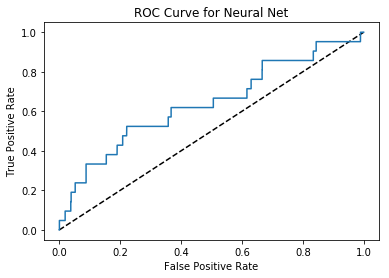

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities: y_pred_prob
a = obj.predict_proba(X_test)
B = np.reshape(a, (-1, 2))
y_pred_prob = B[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, a)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Net')
plt.show()

In [26]:
#finding area under the ROC curve 
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, a)


0.6391336888389932

In [27]:
a

array([0.36295067, 0.17057771, 0.30889481, ..., 0.14238217, 0.61908289,
       0.2173407 ])

/Users/hopeknopf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


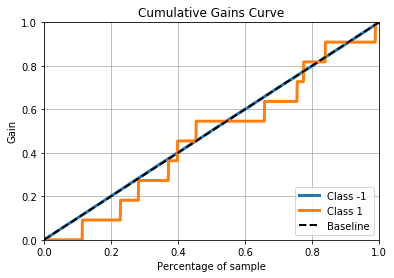

In [28]:
#cumulative gains curve 
predicted_probas = a

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, B)
plt.show()

In [29]:
obj.__str__

<bound method PUAdapter.__str__ of <__main__.PUAdapter object at 0x1071a9208>>

/Users/hopeknopf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


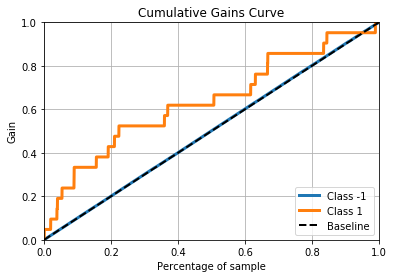

In [30]:
#cumulative gain 
predicted_probas = estimator.predict_proba(X_test)


import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()